In [1]:
from cvxpy import *
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1 

Consider the problem

\begin{align}
\left\{\begin{matrix}
\min 4x_1 + 5|x_2 - 1|\\
2|x_1| + |x_2 - 3| \leq 5\\
\end{matrix}
\right.
\end{align}

and reformulate it as a linear programming problem.

### Solution:

To solve this problem we need to understand the main idea how to change $|\cdot|$ to linear problem. In order to this we need:

$$|x| \rightarrow \min_{x} \Longleftrightarrow z \rightarrow \min_{z, x},\;\; s.t. \; x \leq z,\; -x \leq z $$

Thus, we can reformulate it as a linear programming problem:

\begin{align}
\left\{\begin{matrix}
4x_1 + 5z_2 \rightarrow \min\\
2z_1 + y_2 \leq 5\\
x_1 \leq z_1\\
-x_1 \leq z_1\\
x_2-1 \leq y_2\\
-x_2+3 \leq y_2
\end{matrix}
\right.
\end{align}

In [2]:
n = 5

c = np.asarray([4., 0., 0., 5., 0.])

A = np.asarray([[ 0.,   0.,   2.,   0.,  1.], 
                [ 1.,   0.,  -1.,   0.,  0.], 
                [-1.,   0.,  -1.,   0.,  0.], 
                [ 0.,   1.,   0.,   0., -1.], 
                [ 0.,  -1.,   0.,   0., -1.],
                [ 0.,   1.,   0.,  -1.,  0.], 
                [ 0.,  -1.,   0.,  -1.,  0.]])

b = np.asarray([5, 0, 0, 1, -3., 1., -1.])

x = Variable(n)

constraints = [A@x <= b]

obj = Minimize(c*x)

prob = Problem(obj, constraints)
prob.solve()

print ("Status:", prob.status)
print ("Optimal value", round(prob.value, 3))
print ("Optimal var", np.array(x.value)[:, 0].round(3))

Status: optimal
Optimal value -6.0
Optimal var [-1.5  1.   1.5  0.   2. ]


## Problem 2

Consider a road divided into n segments and illuminated by m lamps. Let $p_j$ be the power of the $j$th lamp. The illumination $I_i$ of the $i$th segment is assumed to be  $\sum^m_{j=1} a_{ij}p_j$, where $a_{ij}$ are known coefficients. Let $I_i^*$ be the desired illumination of road $i$.
We are interested in choosing the lamp powers $p_j$ so that the illuminations $I_i$ are close to the desired illuminations $I_i^*$. Provide a reasonable linear programming formulation of this problem. Note that the wording of the problem is loose and there is more than one possible formulation.


### Solution:

Due to the fact that random matrices do not have a physical sense in this problem, **I will try to introduce a little reality into the system**. We will randomly place the lightings next to the constructed road. Then the matrix coefficients $a_{ij}$ will be approximately the value of the inverse of the distance to a road segment.

**In other words**:
    - (construct road) First of all, we need to construct a road: iteratively jump from point to point along the x axis
    - (construct lights) Then, we put lightings to the system almost the same way
    - (construct illumination) We just find the center of a road and calculate the distance between lights and segments. The inverse of this value (rather square root) will be a coefficient of matrix
    - (generate required illumination) I put the value between 5 and 20 according to СНиП 23-05-95 Естественное и искусственное освещение (table 15)

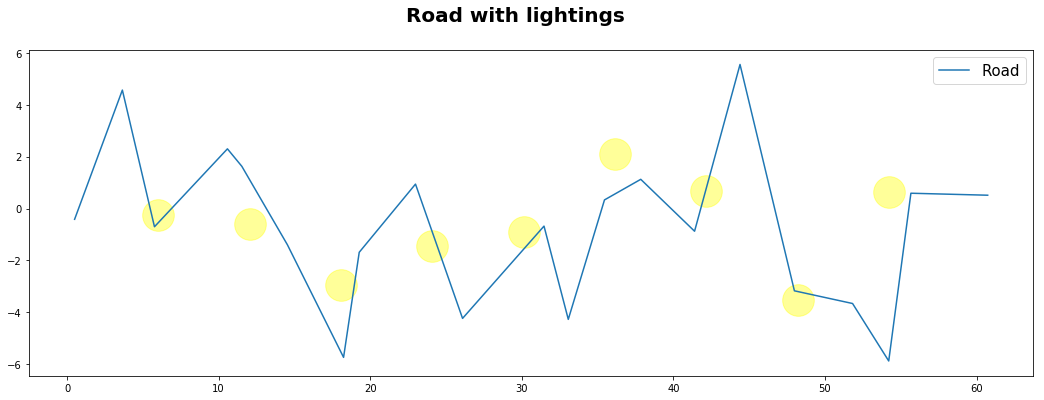

In [3]:
# suppose that we have n segments of a road at a length of L meters each
def construct_road(n):
    length_step = 3
    scale = 3

    # start point:
    x = np.random.normal(loc = 0 * length_step)
    y = np.random.normal(scale = scale)
    
    points = []
    points.append([x, y])

    for i in range(n):
        x = np.random.normal(loc = (i + 1) * length_step)
        y = np.random.normal(scale = scale)
        points.append([x, y])
        
    total_length = points[-1][0] - points[0][0]
        
    return np.array(points), total_length

def construct_lights(m, length):
    scale = 2
    
    length_step = length / (m + 1)
    points = []

    for i in range(m):
        x = (i + 1) * length_step
        y = np.random.normal(scale = scale)
        points.append([x, y])

    return np.array(points)

def construct_illumination(road, lights, resolution = 10):    
    I = []
    
    for num_segm in range(len(road) - 1):
        I_segment = []
        center = (road[num_segm + 1] + road[num_segm]) / 2

        for light in lights: 
            L = np.linalg.norm(center - light)
            I_segment.append(1 / np.sqrt(L))
        
        I.append(I_segment)
    return np.array(I)

def generate_req_illumination(n):
    return np.random.randint(low = 5, high = 20, size = n)

#####################################################################

n = 20
m = 9

np.random.seed(42)
road, length = construct_road(n)
lights       = construct_lights(m, length)

### Ploting
plt.figure(figsize=(18, 6))
plt.suptitle('Road with lightings', fontsize=20, fontweight='bold')
plt.plot(road[:,0], road[:,1], label = 'Road')
plt.scatter(lights[:,0], lights[:,1], c = 'yellow', s = 1000, alpha=0.4)
plt.legend(loc='best', fontsize=15)
plt.show()

In [4]:
# All input data are prepared
n    = 20
m    = 9

# Preparing data
np.random.seed(42)
road, length = construct_road(n)
lights       = construct_lights(m, length)
A            = construct_illumination(road, lights)
I_required   = generate_req_illumination(n)

# Two variables
x = Variable(m)
z = Variable(1)

### The first way (minimizing of error)

Try to minimize:

\begin{align}
\left\{\begin{matrix}
\max_i|(Ax)_i - I_i| \rightarrow \min\\
x_i \geq 0, \; i \in {1, \dots, n}\end{matrix}
\right.
\end{align}

That is equaled to:

\begin{align}
\left\{\begin{matrix}
z\rightarrow \min\\
(Ax - I)_i \leq z, \; i \in {1, \dots, n}\\
(Ax - I)_i \geq - z, \; i \in {1, \dots, n}\\
x_i \geq 0, \; i \in {1, \dots, n}
\end{matrix}
\right.
\end{align}


The value of function: 5.035
Status: optimal
Optimal value of powers:
 [  3.727   0.      3.739   0.     13.174   0.      0.      0.     14.268]


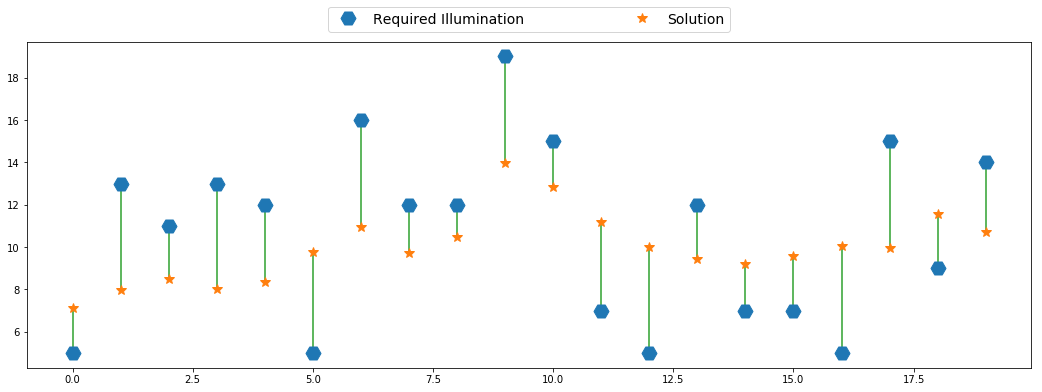

In [5]:
constraints = [A@x - I_required <= z, A@x - I_required >= - z, x >= 0]
obj = Minimize(z)
prob = Problem(obj, constraints)

print('The value of function:', np.round(prob.solve(), 3))
print ("Status:", prob.status)
print ("Optimal value of powers:\n", np.array(x.value)[:,0].round(3))

# Ploting
plt.figure(figsize=(18, 6))
plt.plot(I_required, 'H', label = 'Required Illumination', markersize = 15)
plt.plot(A@np.array(x.value)[:,0], '*', label = 'Solution', markersize = 10)
plt.errorbar(x = np.arange(n), 
             y = np.abs(I_required + A@np.array(x.value)[:,0]) / 2, 
             yerr = np.abs(I_required - A@np.array(x.value)[:,0]) / 2, 
             fmt='none', marker ='s')
plt.legend(bbox_to_anchor=(0.3, 1.03, 0.4, .1), loc=3, ncol=2, mode="expand", borderaxespad=0., fontsize=14)
plt.show()

### The second way
Of course if we have the problem of lightings, then it probably must be satisfied to the following condition: $Ax - I \geq 0$

**Besides**, we can suppose, that we are allowed to have deviations of $\varepsilon = 10\%$
$$ Ax - I \geq - \varepsilon I \Rightarrow Ax - (1 - \varepsilon) I \geq 0$$

Thus, it can be reformulated to the next problem:

\begin{align}
\left\{\begin{matrix}
z\rightarrow \min\\
(Ax - I)_i \leq z, \; i \in {1, \dots, n}\\
(Ax - (1 - \varepsilon)I)_i \geq 0, \; i \in {1, \dots, n}\\
x_i \geq 0, \; i \in {1, \dots, n}
\end{matrix}
\right.
\end{align}

The value of function: 8.539
Status: optimal
Optimal value of powers:
 [  6.785   1.626   4.457   0.     14.195   0.     -0.     -0.     20.166]


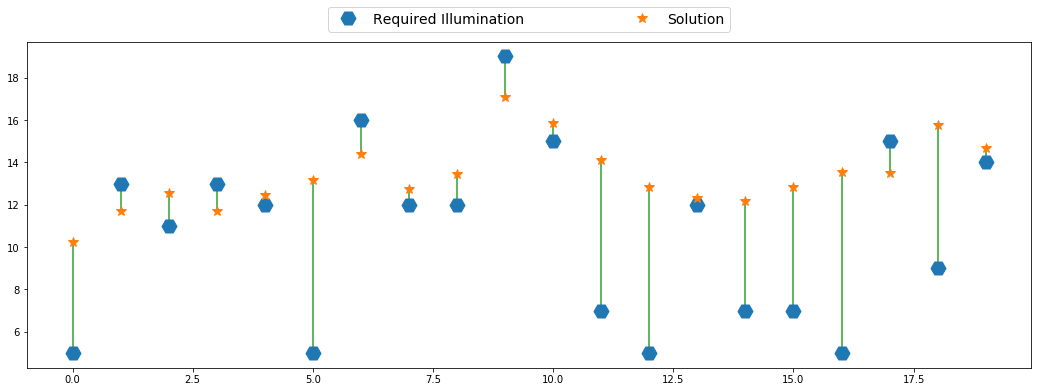

In [6]:
eps = 0.1
constraints = [A@x - I_required <= z, A@x - (1 - eps) * I_required >= 0, x >= 0]
obj = Minimize(z)
prob = Problem(obj, constraints)

print('The value of function:', np.round(prob.solve(), 3))
print ("Status:", prob.status)
print ("Optimal value of powers:\n", np.array(x.value)[:,0].round(3))

# Ploting
plt.figure(figsize=(18, 6))
plt.plot(I_required, 'H', label = 'Required Illumination', markersize = 15)
plt.plot(A@np.array(x.value)[:,0], '*', label = 'Solution', markersize = 10)
plt.errorbar(x = np.arange(n), 
             y = np.abs(I_required + A@np.array(x.value)[:,0]) / 2, 
             yerr = np.abs(I_required - A@np.array(x.value)[:,0]) / 2, 
             fmt='none', marker ='s')
plt.legend(bbox_to_anchor=(0.3, 1.03, 0.4, .1), loc=3, ncol=2, mode="expand", borderaxespad=0., fontsize=14)
plt.show()

We obtained, that almost all of them are satisfying to the requirements!

### The third way (minimizing the amount of power)
This formulation can be more physical, because the first solution can produce big differences of the power's values, minimizing the error. Therefore now we can try to minimize all power that can be produced by lightings. 
We can again assume, that we are allowed to have deviations of $\varepsilon = 10\%$.

Thus:

\begin{align}
\left\{\begin{matrix}
\sum_{i=1}^n x_i \rightarrow \min\\
(Ax - (1 - \varepsilon)I)_i \geq 0, \; i \in {1, \dots, n}\\
x_i \geq 0, \; i \in {1, \dots, n}
\end{matrix}
\right.
\end{align}




The value of function: 46.596
Status: optimal
Optimal value of powers:
 [  6.832   1.646   4.427   0.     13.911   0.      0.      9.221  10.559]


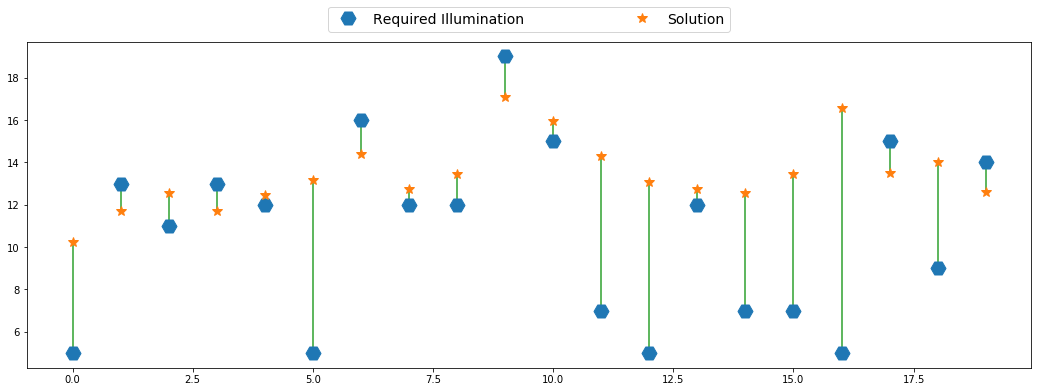

In [7]:
eps = 0.1

constraints = [A@x - (1 - eps) * I_required >= 0, x >= 0]
obj = Minimize(sum_entries(x))
prob = Problem(obj, constraints)

print('The value of function:', np.round(prob.solve(), 3))
print ("Status:", prob.status)
print ("Optimal value of powers:\n", np.array(x.value)[:,0].round(3))

# Ploting
plt.figure(figsize=(18, 6))
plt.plot(I_required, 'H', label = 'Required Illumination', markersize = 15)
plt.plot(A@np.array(x.value)[:,0], '*', label = 'Solution', markersize = 10)
plt.errorbar(x = np.arange(n), 
             y = np.abs(I_required + A@np.array(x.value)[:,0]) / 2, 
             yerr = np.abs(I_required - A@np.array(x.value)[:,0]) / 2, 
             fmt='none', marker ='s')
plt.legend(bbox_to_anchor=(0.3, 1.03, 0.4, .1), loc=3, ncol=2, mode="expand", borderaxespad=0., fontsize=14)
plt.show()

### All in one

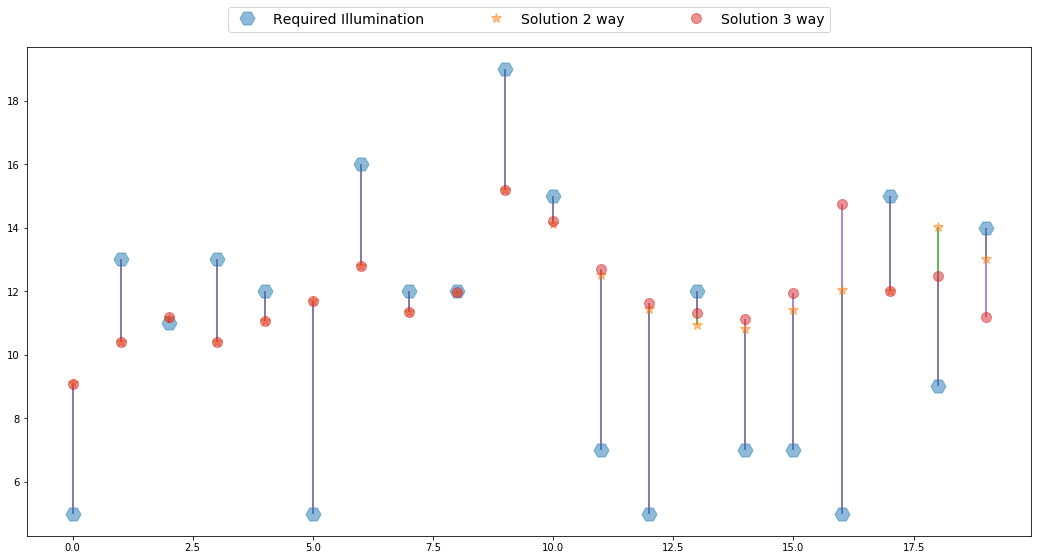

In [8]:
eps = 0.2
constraints = [A@x - I_required <= z, A@x - (1 - eps) * I_required >= 0, x >= 0]
obj = Minimize(z)
prob = Problem(obj, constraints)
prob.solve()

# Ploting
plt.figure(figsize=(18, 9))
plt.plot(I_required, 'H', label = 'Required Illumination', markersize = 15, alpha = 0.5)
plt.plot(A@np.array(x.value)[:,0], '*', label = 'Solution 2nd way', markersize = 10, alpha = 0.5)
plt.errorbar(x = np.arange(n), 
             y = np.abs(I_required + A@np.array(x.value)[:,0]) / 2, 
             yerr = np.abs(I_required - A@np.array(x.value)[:,0]) / 2, 
             fmt='none', marker ='s')

constraints = [A@x - (1 - eps) * I_required >= 0, x >= 0]
obj = Minimize(sum_entries(x))
prob = Problem(obj, constraints)
prob.solve()

# Ploting
plt.plot(A@np.array(x.value)[:,0], 'o', label = 'Solution 3rd way', markersize = 10, alpha = 0.5)
plt.errorbar(x = np.arange(n), 
             y = np.abs(I_required + A@np.array(x.value)[:,0]) / 2, 
             yerr = np.abs(I_required - A@np.array(x.value)[:,0]) / 2, 
             fmt='none', marker ='s')
plt.legend(bbox_to_anchor=(0.2, 1.03, 0.6, .1), loc=3, ncol=3, mode="expand", borderaxespad=0., fontsize=14)
plt.show()

For this data we are obtained enough the same results

## Problem 3

A company produces two kinds of products. A product of the first type requires 1/4 hours of assembly labor, 1/8 hours of testing, and $\$1.2$ worth of raw materials. A product of the second type requires 1/3 hours of assembly, 1/3 hours of testing, and $\$0.9$ worth of raw materials. Given the current personnel of the company, there can be at most 90 hours of assimbly labor and 80 hours of testing, each day. Products of the first and second type have a market value of $\$9$ and $\$8$, perspectively.

1. Formulate a linear programming problem that ccan be used to maximize the daily profit of the company.
2. Consider the following two modifications to the original problem:
    - Suppose that up to 50 hours of overtime assembly labor can be scheduled, at a cost of $\$7$ per hour.
    - Suppose that the raw material supplier provides a $10\%$ discount if the daily bill is above $\$300$.
    
Which of the above two elements can be easily incorporated into the linear programming formulation and how? If one or both are not easy to incorporate, indicate how you might nevertheless solve the problem.

### Solution:

**1**:  Obvious formulation of the problem:

\begin{align}
\left\{\begin{matrix}
-7.8n - 7.1m \rightarrow \min_{n, m}\\
\frac{1}{4}n + \frac{1}{3}m \leq 90\\
\frac{1}{8}n + \frac{1}{3}m \leq 80\\
n \geq 0\\
m \geq 0
\end{matrix}
\right.
\end{align}

In [9]:
n = 2

c = np.asarray([-7.8, -7.1])

A = np.asarray([[ 1/4,   1/3], 
                [ 1/8,   1/3], 
                [ -1.,    0.],
                [  0.,   -1.]])

b = np.asarray([90, 80, 0, 0])


# Variable
x = Variable(n)

# Constraint
constraints = [A@x <= b]

# Objective
obj = Minimize(c*x)

# Solving problem
prob = Problem(obj, constraints)
prob.solve()  # Returns the optimal value

print ("Status:", prob.status)
print ("Optimal value", round(-prob.value, 2))
print ("Optimal var", np.array(x.value)[:,0].round(3))

Status: optimal
Optimal value 2808.0
Optimal var [ 360.    0.]


#### 2:

 - To incorporate the first modification we can introduce new variable T, that costs $7T \$$ for objective function and for constraint T additional hours. Thus:

\begin{align}
\left\{\begin{matrix}
-7.8n - 7.1m  + 7T\rightarrow \min_{n, m, T} \; (!)\\
\frac{1}{4}n + \frac{1}{3}m \leq 90 + T\\
\frac{1}{8}n + \frac{1}{3}m \leq 80\\
0 \leq T \leq 50\; (!)\\
n \geq 0\\
m \geq 0
\end{matrix}
\right.
\end{align}

In [10]:
n = 3

c = np.asarray([-7.8, -7.1, 7.])

A = np.asarray([[ 1/4,   1/3,   -1.], 
                [ 1/8,   1/3,    0.], 
                [ -1.,    0.,    0.],
                [  0.,   -1.,    0.],
                [  0.,    0.,   -1.],
                [  0.,    0.,    1.]])

b = np.asarray([90, 80, 0, 0, 0, 50])


# Variable
x = Variable(n)

# Constraint
constraints = [A@x <= b]

# Objective
obj = Minimize(c*x)

# Solving problem
prob = Problem(obj, constraints)
prob.solve()  # Returns the optimal value

print ("Status:", prob.status)
print ("Optimal value", round(-prob.value, 2))
print ("Optimal var", np.array(x.value)[:,0].round(3))

Status: optimal
Optimal value 4018.0
Optimal var [ 560.    0.   50.]


**2**

 - The second modification cannot be introduced by linearly due to condition. We have:
 $$r = 1.2n + 0.9m$$

If this value more than 300, then $r := 0.9 r$.

But we can to solve 2 problems: with discount and without (last one has already solved).

If we can get a $10\%$ discount for raw materials, then the problem can be reformulated as:

$$0.9r = 0.9 (1.2n + 0.9m) = 1.08n + 0.81m$$

Thus:

\begin{align}
\left\{\begin{matrix}
-7.92n - 7.19m  + 7T\rightarrow \min_{n, m, T} \; (!)\\
\frac{1}{4}n + \frac{1}{3}m \leq 90 + T\\
\frac{1}{8}n + \frac{1}{3}m \leq 80\\
1.2n + 0.9m \geq 300 \; (!)\\ 
0 \leq T \leq 50\\
n \geq 0\\
m \geq 0
\end{matrix}
\right.
\end{align}


In [14]:
n = 3

c = np.asarray([-7.92, -7.19, 7.])

A = np.asarray([[ 1/4,   1/3,   -1.], 
                [ 1/8,   1/3,    0.],
                [-1.2,  -0.9,    0.],                
                [ -1.,    0.,    0.],
                [  0.,   -1.,    0.],
                [  0.,    0.,   -1.],
                [  0.,    0.,    1.]])

b = np.asarray([90, 80, -300, 0, 0, 0, 50])


# Variable
x = Variable(n)

# Constraint
constraints = [A@x <= b]

# Objective
obj = Minimize(c*x)

# Solving problem
prob = Problem(obj, constraints)
prob.solve()  # Returns the optimal value

print ("Status:", prob.status)
print ("Optimal value", round(-prob.value, 2))
print ("Optimal var", np.array(x.value)[:,0].round(3))

Status: optimal
Optimal value 4085.2
Optimal var [ 560.   -0.   50.]


The maximum of minus of the objective function is 4085.2 and the solutuon for the problem without discount is 4018.0. Thus the first one is better result, thus the answer is: $n = 560,\; m = 0,\; f = 4085.2 \$ $
